# PetFinder.my Pawpularity Score / Predict

## Imports

In [1]:
# Imports
import os
import numpy as np
from IPython.display import display

# Import utility libs
import petfinder_pawpularity_config as config
import petfinder_pawpularity_lib as mllib
tf_strategy = mllib.tf_strategy()

'TensorFlow Version: 2.8.0'

'TensorFlow Strategy: _DefaultDistributionStrategy'

'Built With GPU Support: True'

'Built With CUDA: True'

'Device: /device:GPU:0'

In [2]:
# Enable retina display
%config InlineBackend.figure_format = "retina"

# Load Tensorboard
%load_ext tensorboard

## Settings

In [3]:
# Settings
settings, debug = config.get_settings(
    process="predict",
    fallback_mode="full"
)
mllib.show_dict(settings)

'Settings: local-predict-full'

,Key,Value
0,debug,True
1,model_load_dir,models
2,model_save_dir,models
3,dataset_dir_src,../input/petfinder-pawpularity-score
4,dataset_dir_cut,../input/petfinder-pawpularity-score
5,dataset_dir_copy,dataset-copy
6,dataset_batch_size,64
7,dataset_image_size,"(150, 150)"
8,dataset_cut_ratio,1.0
9,dataset_shrink_ratio,1.0


## Prepare data

'../input/petfinder-pawpularity-score'

'Load training data from ../input/petfinder-pawpularity-score/train.csv'

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,0,0,0,20


Train / Validate / Test datasets items: 6912 / 1984 / 960

Train dataset:
Cause: could not parse the source code of <function <lambda> at 0x7ff0683478b0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7ff0683478b0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


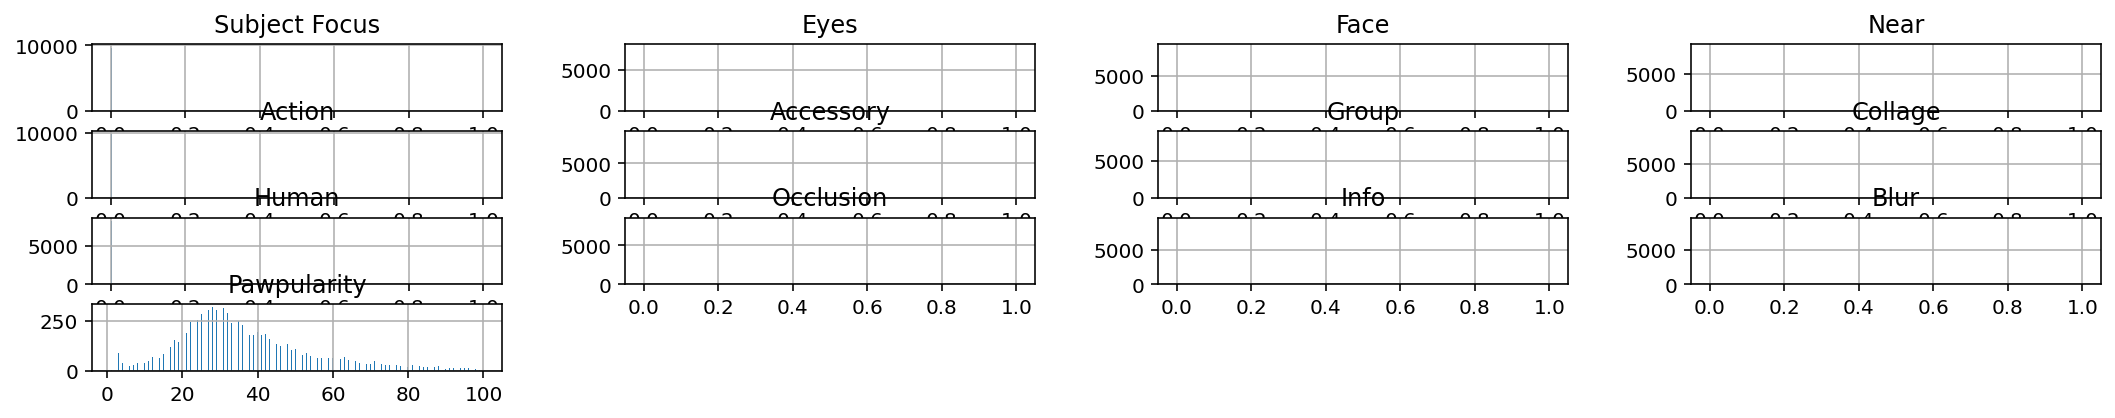

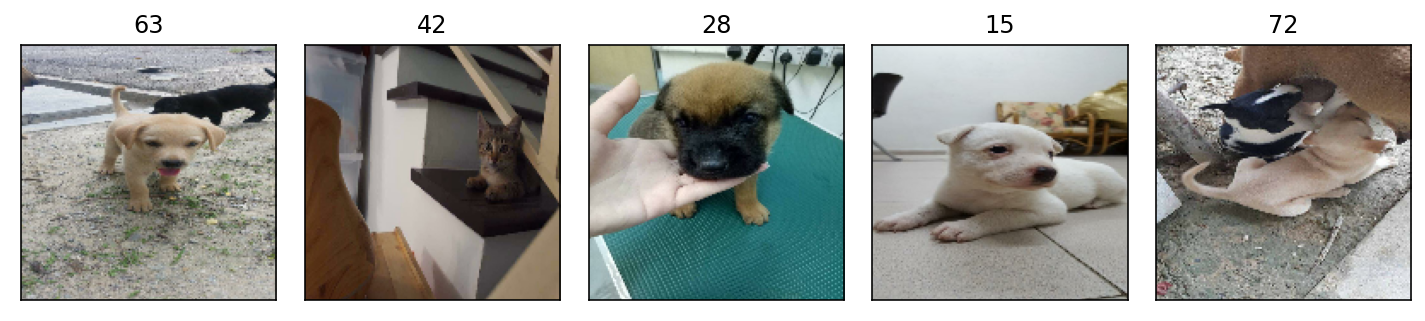

Validate dataset:


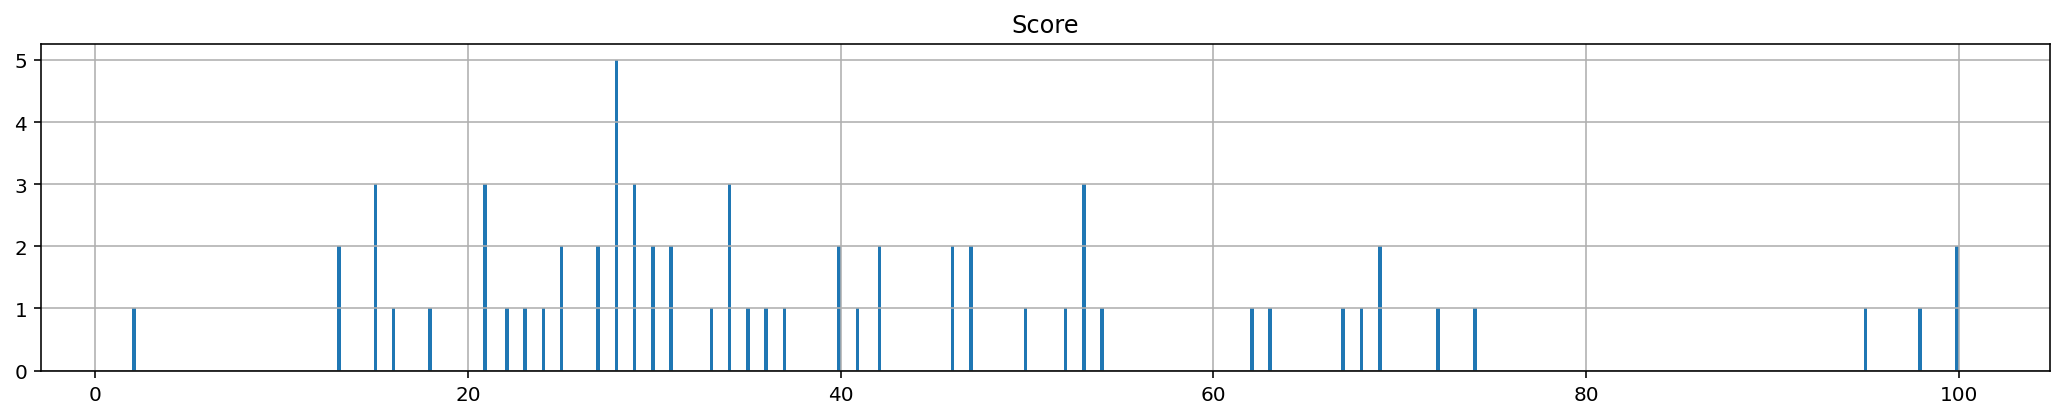

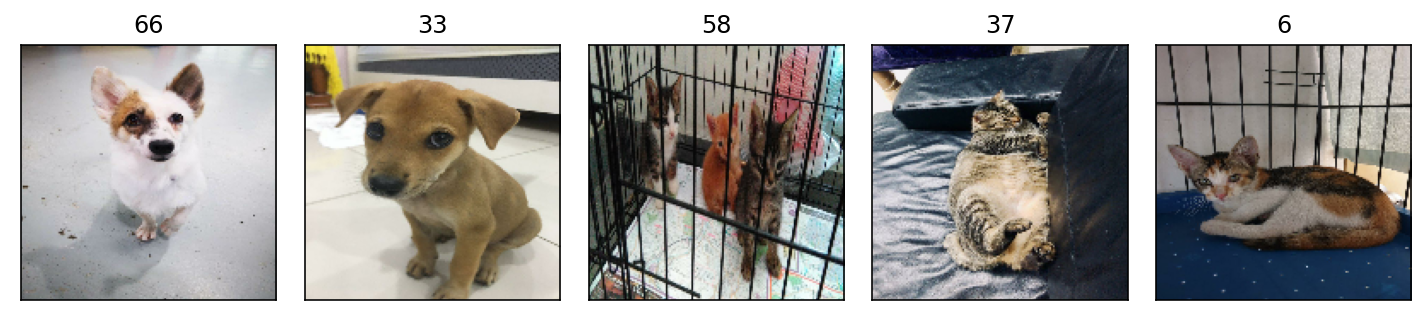

Test dataset:


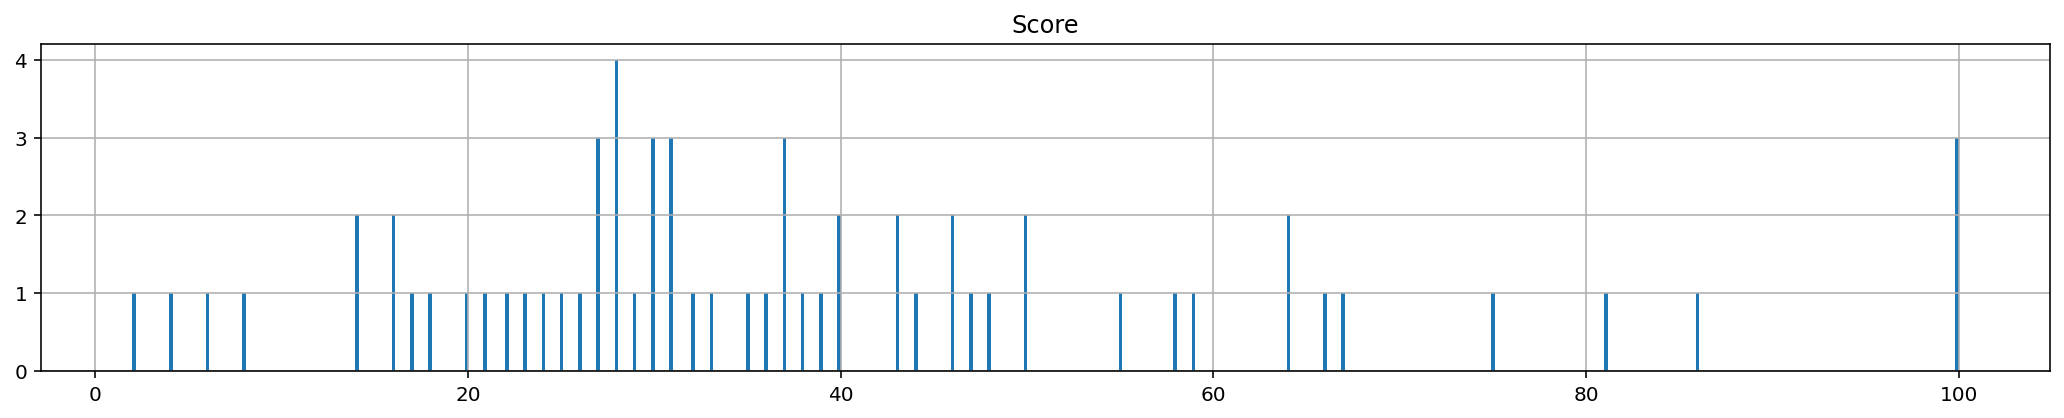

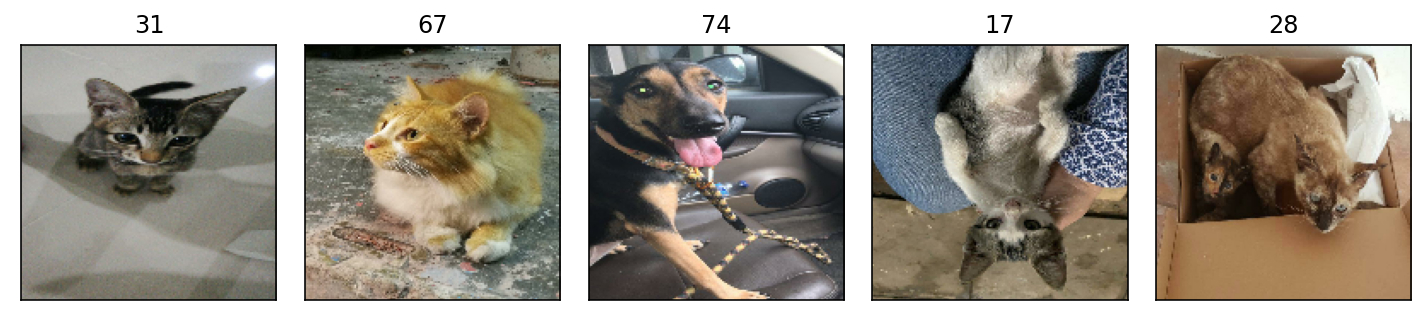

CPU times: user 17.8 s, sys: 1.91 s, total: 19.7 s
Wall time: 13 s


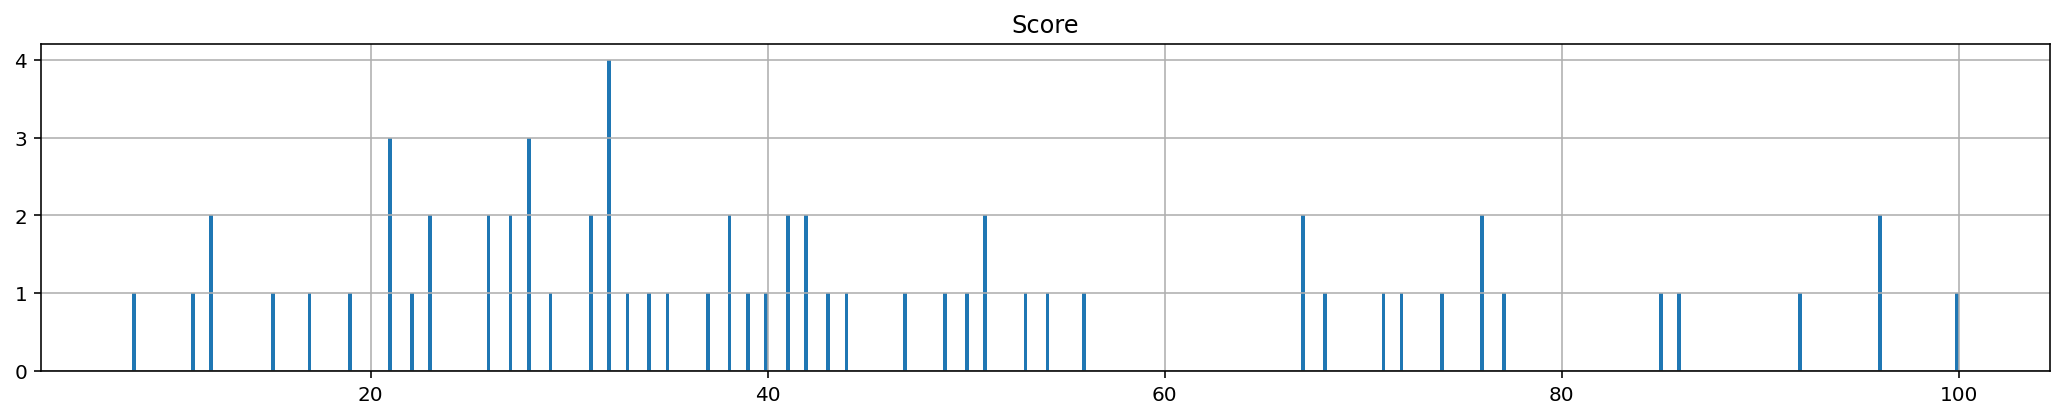

In [4]:
%%time
# Cut training data
dataset_dir = mllib.cut_training_data(
    cut_ratio=settings["dataset_cut_ratio"], 
    dataset_dir_src=settings["dataset_dir_src"], 
    dataset_dir_cut=settings["dataset_dir_cut"]
)
display(dataset_dir)

# Train data
training_data = mllib.load_training_data(dataset_dir)
if debug: 
    display(training_data)
    training_data.hist(bins=500, figsize=(18,3))

# Make training data
map_image_score_fn = lambda image, features, score, file_id: (image, score)  
train_dataset, validate_dataset, test_dataset = mllib.make_training_validate_test_data(
    dataset=mllib.load_training_dataset(
        dataset_dir=dataset_dir,
        mapping_data=training_data,
        batch_size=settings["dataset_batch_size"],
        shuffle=settings["dataset_shuffle"],
        seed=settings["dataset_shuffle_seed"],
        image_size=settings["dataset_image_size"],
    ),
    split_ratios=settings["dataset_split_ratios"],
    shrink_ratio=settings["dataset_shrink_ratio"],
    prefetch=settings["dataset_prefetch"],
)

# Training data infos
print("Train / Validate / Test datasets items: %s / %s / %s" % (
    settings["dataset_batch_size"] * train_dataset().cardinality().numpy(), 
    settings["dataset_batch_size"] * validate_dataset().cardinality().numpy(), 
    settings["dataset_batch_size"] * test_dataset().cardinality().numpy()
))
if debug:
    print("")
    print("Train dataset:")
    mllib.plot_images_scores_from_dataset(train_dataset().take(1).map(map_image_score_fn))
    print("Validate dataset:")
    mllib.plot_images_scores_from_dataset(validate_dataset().take(1).map(map_image_score_fn))
    print("Test dataset:")
    mllib.plot_images_scores_from_dataset(test_dataset().take(1).map(map_image_score_fn))

## Predict

In [5]:
# Prepare model parameters
def get_model_parameters(settings):
    dataset_image_size = settings["dataset_image_size"]
    model_parameters = {
        "model_id": "model_1",
        "model_prefix": mllib.cut_suffix(settings["dataset_cut_ratio"]),
        "model_base": "xception",
        "input_shape": [dataset_image_size[0], dataset_image_size[1], 3],
        "input_shape_features": len(mllib.feature_fields),
        "output_size": 1,
        "dropout_rate": 0.3,
        "learning_rate": 5e-4,
        "dense_layers": "100",
        "dense_layers_activation": "elu",
        "preload_weights": None,
    }
    model_name = mllib.get_model_name(model_parameters)
    model_parameters["model_name"] = model_name
    return model_parameters
    
model_parameters = get_model_parameters(settings)
mllib.show_dict(model_parameters)

,Key,Value
0,model_id,model_1
1,model_prefix,
2,model_base,xception
3,input_shape,"[150, 150, 3]"
4,input_shape_features,12
5,output_size,1
6,dropout_rate,0.3
7,learning_rate,0.0005
8,dense_layers,100
9,dense_layers_activation,elu


In [6]:
%%time
# Load model
with tf_strategy.scope():
    model = mllib.setup_model(model_parameters)
    model_file = mllib.load_model(model, settings["model_load_dir"])
    print("Loaded Weights: %s" % model_file)

Model: "model_1-xception-input-150x150x3-dense-100-elu-dropout-0.300"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
      

*** Test Image # 1
>>> FAILURE
>>> Predicted score: 0 vs 36


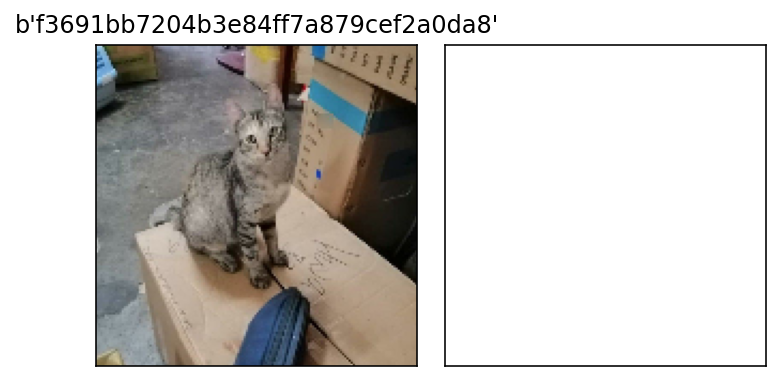


*** Test Image # 2
>>> FAILURE
>>> Predicted score: 0 vs 29


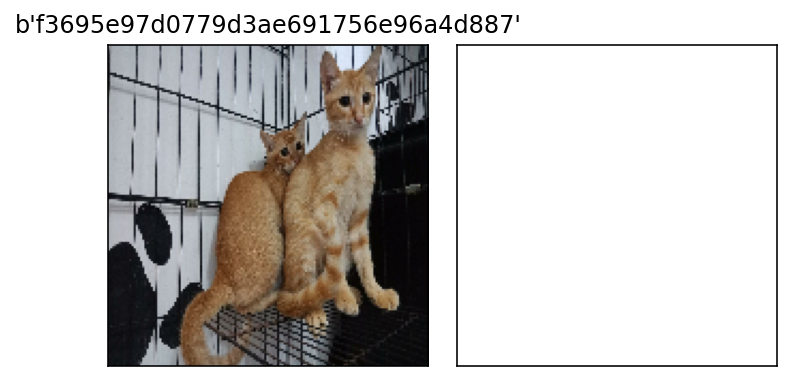


*** Test Image # 3
>>> FAILURE
>>> Predicted score: 0 vs 30


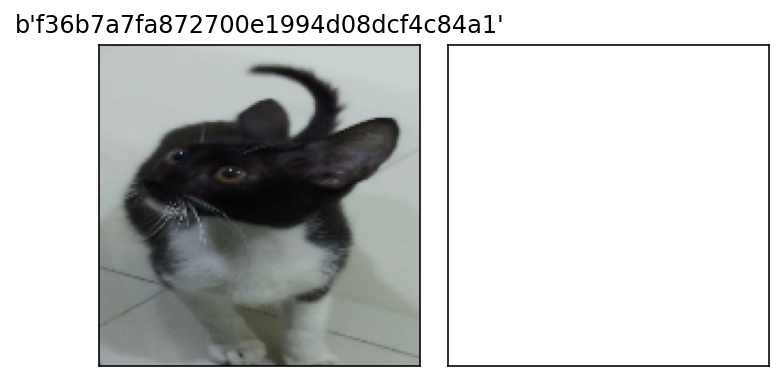


*** Test Image # 4
>>> FAILURE
>>> Predicted score: 0 vs 44


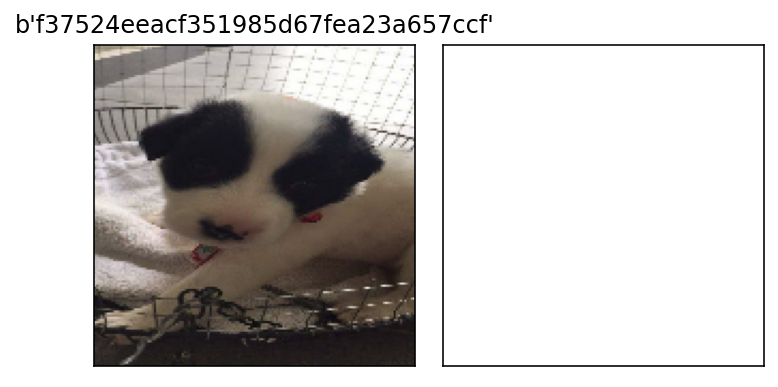


*** Test Image # 5
>>> FAILURE
>>> Predicted score: 0 vs 68


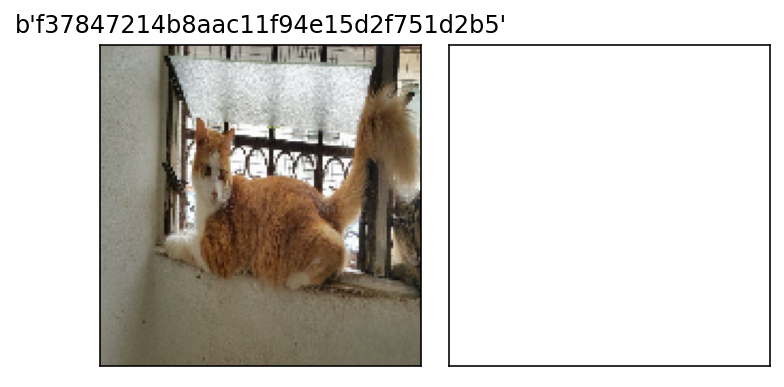


CPU times: user 22.4 s, sys: 1.92 s, total: 24.4 s
Wall time: 6.97 s


In [7]:
%%time
# Predict on test dataset
if debug:
    with tf_strategy.scope():
        images, features, scores, file_ids, *_ = mllib.load_images_scores_from_dataset(test_dataset().shuffle(100).take(1))
        for index in range(len(images[:5])):
            print("*** Test Image #",index+1)
            mllib.predict(
                model=model, 
                image=images[index],
                features=features[index],
                label=file_ids[index],
                true_score=scores[index], 
            )
            print("")

## Score

### Train

In [8]:
%%time
# Score train submission data
train_score, train_scored_data = mllib.score_submission_data(
    submission_data=mllib.infer_submission_data(
        dataset=train_dataset,
        model=model, 
        take=settings["score_sample_size"]
    ), 
    training_data=training_data
)
display("Train Submission RMSE Score [Samples=%i]: %f" % (settings["score_sample_size"], train_score))
if debug: display(train_scored_data)

'Train Submission RMSE Score [Samples=10]: 42.563904'

,index,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,predicted_Pawpularity
0,0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63.0,-0.0
1,1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42.0,0.0
2,2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28.0,-0.0
3,3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15.0,0.0
4,4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,635,107ae50725a7d1b403105eb2ab6d5f60,0,0,0,0,0,0,0,0,0,0,0,0,30.0,0.0
636,636,10802a83bd5dc77ec9548c9e8d0c8abf,0,0,1,1,0,0,0,0,0,0,0,1,49.0,0.0
637,637,108519f539e734434cd6819c46f297ff,0,1,1,1,0,0,0,0,0,0,0,0,84.0,0.0
638,638,108b665bd65d664d838de0fa435105e4,0,1,1,1,0,0,0,0,0,0,0,0,33.0,-0.0


CPU times: user 53.8 s, sys: 1.66 s, total: 55.4 s
Wall time: 9.71 s


### Validate

In [9]:
%%time
# Score validate submission data
validate_score, validate_scored_data = mllib.score_submission_data(
    submission_data=mllib.infer_submission_data(
        dataset=validate_dataset,
        model=model, 
        take=settings["score_sample_size"]
    ), 
    training_data=training_data
)
display("Validate Submission RMSE Score [Samples=%i]: %f" % (settings["score_sample_size"], validate_score))
if debug: display(validate_scored_data)

'Validate Submission RMSE Score [Samples=10]: 43.088172'

,index,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,predicted_Pawpularity
0,0,b27a0c647b10ba784846e33006934780,0,1,1,1,0,0,0,0,0,0,0,0,66.0,0.0
1,1,b27d03d4a6096b09d48b480ff41da753,0,1,1,1,0,0,0,0,0,0,0,0,33.0,0.0
2,2,b2818a7542424d8c804d3db04591d8b7,0,1,1,0,0,0,1,0,0,1,0,0,58.0,0.0
3,3,b285df6b825d55eb6fe2da7ec613f719,0,1,1,1,0,0,0,0,0,0,0,0,37.0,0.0
4,4,b28b784d0d79c33b413f3554af315dec,0,1,1,1,0,0,0,0,0,0,0,0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,635,c2b3f8cc8ff08227f8ca3a8362b44253,0,0,0,0,0,0,1,0,0,0,0,0,53.0,0.0
636,636,c2ba097979ee7c3bbb0c16075d89726b,0,0,1,1,0,0,1,0,0,1,1,0,54.0,0.0
637,637,c2c1db008e551b9f11f79c5ad6db621b,0,1,1,1,0,0,0,0,0,0,0,0,50.0,0.0
638,638,c2cae93a85346c5d64d3655a6c11b15c,0,0,0,1,0,0,0,0,0,0,0,0,17.0,-0.0


CPU times: user 52.4 s, sys: 1.69 s, total: 54.1 s
Wall time: 8.57 s


### Test

In [10]:
%%time
# Score test submission data
test_score, test_scored_data = mllib.score_submission_data(
    submission_data=mllib.infer_submission_data(
        dataset=test_dataset,
        model=model, 
        take=settings["score_sample_size"]
    ), 
    training_data=training_data
)
display("Test Submission RMSE Score [Samples=%i]: %f" % (settings["score_sample_size"], test_score))
if debug: display(test_scored_data)

'Test Submission RMSE Score [Samples=10]: 43.548805'

,index,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,predicted_Pawpularity
0,0,e5ddcd6d3527d3432aa570abd0e182d0,0,1,1,1,0,0,0,0,0,0,0,0,31.0,0.0
1,1,e5e9270e93bca9589f69469e8795c9d6,0,0,1,1,0,0,0,0,0,0,0,0,67.0,0.0
2,2,e5ec7edab9619ba4f928719667e555cc,0,1,1,1,0,0,0,0,0,0,0,0,74.0,-0.0
3,3,e5f657d53695a87859c2dd7d265e053a,0,1,1,1,0,0,0,0,1,0,0,0,17.0,-0.0
4,4,e5fa12963fab8e7e02fbc70df6d120f0,0,1,1,0,0,0,1,0,0,0,0,0,28.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,635,f61111cce574f90017c7936f5d8a28b1,0,1,1,1,0,0,0,0,0,0,0,0,65.0,0.0
636,636,f613bffd8aa54abb63ca11cac032e245,0,0,1,1,0,0,0,0,0,0,0,1,22.0,0.0
637,637,f61eb271ee49f5f183931ef9e5fe7b3a,0,1,1,1,0,0,0,0,0,0,0,0,19.0,0.0
638,638,f6282e6ae0abf9d304bbb5e5056c70a2,0,1,1,1,0,0,0,0,1,0,1,0,45.0,-0.0


CPU times: user 53.8 s, sys: 1.44 s, total: 55.2 s
Wall time: 8.92 s


## Cleanup

In [11]:
%%time
if settings["cleanup_data_flag"]: 
    mllib.delete_training_data(cut_ratio=settings["dataset_cut_ratio"], dataset_dir_cut=settings["dataset_dir_cut"])

CPU times: user 9 µs, sys: 1e+03 ns, total: 10 µs
Wall time: 14.1 µs
